In [55]:
import numpy as np
import cv2
import matplotlib.pylab as plt
%matplotlib inline

def show(img):
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.set_axis_off()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
def show_gray(img):  
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.set_axis_off()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))    
    
def show_imgs(imgs):
    if (len(imgs) > 15):
        columns_cnt = 15
    else:
        columns_cnt = len(imgs)
    rows_cnt = len(imgs) // columns_cnt + 1   
        
    fig = plt.figure(figsize=(20,20))
    for count, img in enumerate(imgs):
        a = fig.add_subplot(rows_cnt, columns_cnt, count + 1)
        a.set_axis_off()
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  
        
def read_test_params(img_number):
    with open("parameters012.txt") as f:
        content = f.readlines()
    line = content[img_number + 1]    
    pic, a, b, c, d, e, f, g = line.split(',')
    
    print('Truth values:')
    print('Coefficients a_true:', a)
    print('Coefficients b_true:', b)
    print('Coefficients c_true:', c)
    print('Coefficients d_true:', d)
    print('Coefficients e_true:', e)
    print('Coefficients f_true:', f)
    print('Coefficients g_true:', g)

In [56]:
import glob
list_of_names = glob.glob("13/*")

dic_of_img = {}
for name in list_of_names:
    img = cv2.imread(name)
    p = name.split('/')
    dic_of_img[p[1]] = img

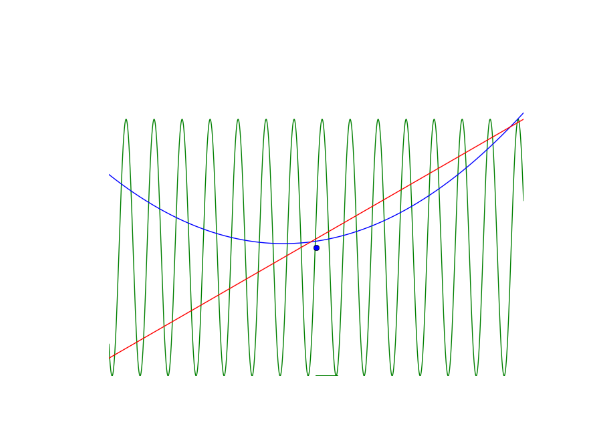

In [57]:
img = dic_of_img['4.png']
show(img)

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import curve_fit

In [59]:
def fit_linear(X_train, y_train):
    N = len(X_train)
    X_train = X_train.reshape((N,1))
    
    model = LinearRegression()
    model.fit(X_train, y_train)

    f = model.coef_[0]
    g = model.intercept_
    return f, g

def fit_polynom(X_train, y_train):
    N = len(X_train)
    X_train = X_train.reshape((N,1))
    degree = 2
    poly = PolynomialFeatures(2) #x -> 1, x , x^2
    X_train_poly = poly.fit_transform(X_train)

    model = LinearRegression(fit_intercept=False)
    model.fit(X_train_poly, y_train)

    e, d, c = model.coef_
    return c, d, e

def fit_sin(X_train, y_train): 
    X_train = X_train.flatten()

    x_plus = X_train[X_train >= 0]
    y_plus = y_train[X_train >= 0]

    x_minus = X_train[X_train < 0]
    y_minus = y_train[X_train < 0]


    tuple_plus = []
    for i in np.arange(len(x_plus)):
        tuple_plus.append((x_plus[i], y_plus[i]))

    tuple_minus = []
    for i in np.arange(len(x_minus)):
        tuple_minus.append((x_minus[i], y_minus[i]))


    def desc(tuple_):
        fst, snd = tuple_
        return fst

    tuple_plus.sort(key=desc)
    tuple_minus.sort(key=desc, reverse=True)   


    def get_one(tuple_list, epsilon = 1e-2):
        for i in np.arange(len(tuple_list)):
            x, y = tuple_list[i]
            if (np.abs(y - 1) < epsilon):
                
                return x, y, 1
            
            if (np.abs(y + 1) < epsilon):
                
                return x, y, -1
            
    def get_one_new(tuple_list, epsilon = 1e-2):
        for i in np.arange(len(tuple_list)):
            x, y = tuple_list[i]
            if (np.abs(y - 1) < epsilon):
                x_lst = []
                y_lst = []
                for epsilon in [0.01, 0.03]:
                    while(np.abs(y - 1) < epsilon):
                        x_lst.append(x)
                        y_lst.append(y)
                        i += 1
                        x, y = tuple_list[i]

                return x, y, 1

            if (np.abs(y + 1) < epsilon):
                x_lst = []
                y_lst = []
                for epsilon in [0.01, 0.03]:
                    while(np.abs(y + 1) < epsilon):
                        x_lst.append(x)
                        y_lst.append(y)
                        i += 1
                        x, y = tuple_list[i]

                return x, y, -1


    def get_T(x1, x2, sign1, sign2):
        if (sign1 * sign2 > 0):
            return 2*np.pi / np.abs(x1 - x2)
        else:
            return np.pi / np.abs(x1 - x2) 

    if (get_one(tuple_minus) is None or get_one(tuple_plus) is None):
        a = 0
        b = 0
    else:    
        try:
            x1, y1, sign1 = get_one_new(tuple_plus)
            x2, y2, sign2 = get_one_new(tuple_minus)    

            T = get_T(x1, x2, sign1, sign2)
            popt, pcov = curve_fit(sin, X_train, y_train, p0=(T, 0.5), bounds=(0, [T, 1.]))
            
        except Exception:
            x1, y1, sign1 = get_one(tuple_plus)
            x2, y2, sign2 = get_one(tuple_minus)    

            T = get_T(x1, x2, sign1, sign2)
            popt, pcov = curve_fit(sin, X_train, y_train, p0=(T, 0.5), bounds=(0, [T, 1.]))
            
        a, b = popt
    return a, b  

def key_min(tuple_):
    k, v = tuple_
    mse, _ = v
    return mse


def sin(x, a, b):
    return np.sin(a * x + b)

In [60]:
def key_snd(tuple_):
    fst, snd = tuple_
    
    return snd

def key_fst(tuple_):
    fst, snd = tuple_
    
    return fst

def is_first_min_or_max_and_second_min_or_max(tuple_list, y1, y2):
    mid_x = 0
    mid_y = 0
    N = len(tuple_list)
    mid_index = (int)(N // 2)
    for i in np.arange(N):
        x, y = tuple_list[i]
        if (np.abs(x - 0.0) < 1e-5):
            mid_x = x
            mid_y = y
            mid_index = i
            break    
                 
    fst_list = tuple_list[:mid_index] 
    snd_list = tuple_list[mid_index:]
    
    _, left_min_y = min(fst_list, key=key_snd)
    _, left_max_y = max(fst_list, key=key_snd)
    
    _, right_min_y = min(snd_list, key=key_snd)
    _, right_max_y = max(snd_list, key=key_snd)
    
    if ((np.abs(y1 - left_min_y) < 1e-2) and (np.abs(y2 - right_min_y) < 1e-2)):
        return True
    
    if ((np.abs(y1 - left_max_y) < 1e-2) and (np.abs(y2 - right_max_y) < 1e-2)):
        return True
    
    return False
            

def is_first_min_second_max(y_train, y1, y2):
    min_y = min(y_train)
    max_y = max(y_train)

    if ((np.abs(y1 - min_y) < 1e-2) and (np.abs(y2 - max_y) < 1e-2)):
        return True
    
    if ((np.abs(y1 - max_y) < 1e-2) and (np.abs(y2 - min_y) < 1e-2)):
        return True
    
    return False
    
    

def get_method(X_train, y_train):
    tuple_list = []
    for i in np.arange(len(X_train)):
        tuple_list.append((X_train[i], y_train[i]))
    tuple_list.sort(key=key_fst)   

    
    x1, y1 = tuple_list[0]
    x2, y2 = tuple_list[len(tuple_list) - 1]
    
    if (is_first_min_or_max_and_second_min_or_max(tuple_list, y1, y2)):
        return 'polynom'
    
    if (is_first_min_second_max(y_train, y1, y2)):
        return 'linear'
    
    return 'sin'

In [61]:
result_dic = {}

In [62]:
for img_name in dic_of_img.keys():
    img = dic_of_img[img_name]
    
    #найдем координаты центра
    im_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh, im_bw = cv2.threshold(im_gray, 100, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (8, 8))
    erosion = cv2.erode(im_bw, kernel, iterations = 1)
    
    connectivity = 4
    # Perform the operation
    output = cv2.connectedComponentsWithStats(erosion, connectivity, cv2.CV_32S)
    # Get the results
    # The first cell is the number of labels
    num_labels = output[0]
    # The second cell is the label matrix
    labels = output[1]
    # The third cell is the stat matrix
    stats = output[2]
    # The fourth cell is the centroid matrix
    centroids = output[3]
    
    if (num_labels !=2):
        print("Error")
    
    cX, cY = centroids[1]
    
    #закрасим центр
    def get_R(area):
        R = np.sqrt((area / np.pi))
        return R

    area = stats[1][4]
    R = get_R(area)
    cv2.circle(img, ((int)(cX), (int)(cY)) ,(int)(R) , (255,255,255) ,10)
    
    #Найдем масштаб, по x и по y
    im_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh, im_bw = cv2.threshold(im_gray, 100, 255, cv2.THRESH_OTSU)
    kernel_1 = np.ones((1, 32),np.uint8)
    closing_1 = cv2.morphologyEx(im_bw, cv2.MORPH_CLOSE, kernel_1)
    closing_1 = 255 - closing_1
    connectivity = 8
    # Perform the operation
    output = cv2.connectedComponentsWithStats(closing_1, connectivity, cv2.CV_32S)
    # Get the results
    # The first cell is the number of labels
    num_labels = output[0]
    # The second cell is the label matrix
    labels = output[1]
    # The third cell is the stat matrix
    stats = output[2]
    # The fourth cell is the centroid matrix
    centroids = output[3]
    
    line = []
    for num in np.arange(num_labels):
        if (num == 0):
            continue
        stat = stats[num]
        x, y = stat[0], stat[1]
        width, hight = stat[2], stat[3]
        line.append((x,y,width, hight))
        
    def key_distance(tuple_):
        x, y, _, _ = tuple_
        return y

    line.sort(key=key_distance, reverse=True)    
    
    #закрашиваем отрезок с масштабом
    x, y, width, hight = line[0]
    scale_x = width
    scale_y = y - hight - cY
    cv2.line(img, ((int)(x), (int)(y)) ,((int)(x + width), (int)(y)) , (255,255,255) ,10)
    
    boundaries = {"red": ([0, 0, 0], [90, 90, 255]),
                  "green":([0, 0, 0],[80, 255, 80]),
                  "blue":([0, 0, 0],[255, 90, 90])}
    
    methods = []
    for color in boundaries.keys():
        lower, upper = boundaries[color]
        lower = np.array(lower, dtype = "uint8")
        upper = np.array(upper, dtype = "uint8")

        mask = cv2.inRange(img, lower, upper)
        red_img = cv2.bitwise_and(img, img, mask = mask)

        im_gray = cv2.cvtColor(red_img, cv2.COLOR_BGR2GRAY)
        thresh, im_bw = cv2.threshold(im_gray, 100, 255, cv2.THRESH_OTSU)

        src, contour, hierarchy = cv2.findContours(im_bw,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)

        X_train = []
        y_train = []

        for cont in contour:
            for arr in cont:
                x, y = arr[0]
                x_ = (x - cX) / scale_x
                y_ = (y - cY) / (-scale_y)
                X_train.append(x_)
                y_train.append(y_)

        X_train = np.array(X_train)
        y_train = np.array(y_train)
        method_name = get_method(X_train, y_train)
        methods.append((method_name, X_train, y_train))
        
        print(method_name, 'is', color)
        
    print(img_name)    
    name1, _, _ = methods[0]   
    name2, _, _ = methods[1]
    name3, _, _ = methods[2] 
    
    if (name1 != name2 and name2 != name3 and name1 != name3):
        for method in methods:
            name, X_train, y_train = method
            if (name == 'linear'):
                f, g = fit_linear(X_train, y_train)

            if (name == 'polynom'):
                c, d, e = fit_polynom(X_train, y_train)

            if (name == 'sin'):
                a, b = fit_sin(X_train, y_train)
    else:
        if (name1 == 'linear'):
            name2, X_train2, y_train2 = methods[1]
            name3, X_train3, y_train3 = methods[2] 
            if (len(X_train2) > len(X_train3)):
                #name2 - sin, name3 - polynom
                a, b = fit_sin(X_train2, y_train2)
                c, d, e = fit_polynom(X_train3, y_train3)
            else:
                #name3 - sin, name2 - polynom
                a, b = fit_sin(X_train3, y_train3)
                c, d, e = fit_polynom(X_train2, y_train2)

    arr = img_name.split('.') 
    num = int(arr[0])
    result_dic[num] = [a, b, c, d, e, f, g]  
    print(a, b, c, d, e, f, g)

linear is blue
sin is green
polynom is red
6.png
1.33517687778 0.821652087457 0.0101253417955 0.018791544607 0.0164309291314 0.0989224753674 0.112686780377
linear is blue
sin is green
polynom is red
1.png
1.57079632679 0.565130822296 0.00900341199347 0.0291092165129 0.0566245882503 0.0897733089963 0.195990648939
linear is blue
polynom is green
sin is red
10.png
0.684706091167 0.401874978867 0.0117458457194 0.00410334670158 0.0709514533135 0.0933906756164 0.163034815637
linear is blue
sin is green
polynom is red
3.png
0.716873491423 0.876401104874 0.0117045301686 0.00444581284563 0.0261491065115 0.101703608822 0.0873539411831
polynom is blue
linear is green
sin is red
8.png
3.91179916092 0.431351669703 0.00957830288822 0.0234868997509 0.0101914089206 0.108485529157 0.025634230437
sin is blue
linear is green
polynom is red
12.png
3.92500256979 0.40263030698 0.0108238463241 0.0239375292931 0.0298845946986 0.102126337674 0.135167287317
sin is blue
linear is green
polynom is red
0.png
0.400

In [64]:
res = 'pic,a,b,c,d,e,f,g\n'
for k, params in result_dic.items():
    res += str(k) + ','
    for i in np.arange(len(params)):
        if (i == len(params) - 1):
            res += str(params[i])
        else:
            res += str(params[i]) + ','
        
    res += '\n'    

with open('parameters.txt', 'w') as f:
    f.write(res)